In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.environ)

try:
    import dataretrieval
except ImportError:
    print("dataretrieval not found. Installing...")
    !pip install dataretrieval
    import dataretrieval # Import again after installation

from dataretrieval import nwis # hydrological time-series data from USGS

# Use scikit-learn to grid search the number of neurons
!pip install scikit-learn==1.5.2 # TO AVOID AttributeError: 'super' object has no attribute '__sklearn_tags__'
import sklearn
print(sklearn.__version__)
!pip install hydroeval
import hydroeval as he
from sklearn.model_selection import GridSearchCV  #  hyperparameter tuning
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.constraints import MaxNorm

#!pip install scikeras
#from scikeras.wrappers import KerasRegressor

try:
    from scikeras.wrappers import KerasRegressor
except ImportError:
    print("scikeras not found. Installing...")
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor



import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Imports several common regression evaluation metrics from scikit-learn:
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)




from numpy import array
!pip install permetrics
from permetrics.regression import RegressionMetric
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.5.3.2-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.5.82-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn9-cuda-12', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.22.3-1+cuda12.5', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.22.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'MODEL_PROXY_HOST': 'https://mp.kaggle.net', 'HOSTNAME': '4d1c94793202', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.5 brand=unknown,driver>=470,driver<471 brand=grid,driver>=470,driver<471 brand=tesla,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 bran

In [2]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
  #'12305000'
#  '12322000'
  #'13092747'
  '13150430'
#  '13154500'
  #"13190500"
 # "13211205"
#  "13307000"
#  "13340000"
]

#units_day = 365
#missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
#summer_missing_data_threshold = 0.90 * (30+31+31)

In [3]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va']
filtered_df = site_info_df[columns_to_save]

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )

dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
# Extracts Date, Month, and Year components from the datetime column.
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

# https://www.tensorflow.org/tutorials/structured_data/time_series
# https://www.scirp.org/journal/paperinformation?paperid=142149
# https://etasr.com/index.php/ETASR/article/view/10595

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)

prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)

prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date','Days_Since_October_1st'
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 4 , 8+1 ))

print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

print("df_cleaned:",df_cleaned)

print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

# gap

# Calculate time difference between consecutive dates
df_cleaned['Gap'] = df_cleaned['Date'].diff()

# Filter rows where the gap is more than expected (e.g., > 1 day)
expected_freq = pd.Timedelta(days=1)
gaps = df_cleaned[df_cleaned['Gap'] > expected_freq]

print("gaps",gaps)

site_info_df:   agency_cd   site_no                                     station_nm  \
0      USGS  13150430  SILVER CREEK AT SPORTSMAN ACCESS NR PICABO ID   

  site_tp_cd    lat_va     long_va  dec_lat_va  dec_long_va coord_meth_cd  \
0         ST  431924.1  1140630.06   43.323361   -114.10835             N   

  coord_acy_cd  ... reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  \
0            S  ...              C   NNNNNNNN          NaN      NaN   

   aqfr_type_cd well_depth_va hole_depth_va depth_src_cd  project_no  \
0           NaN           NaN           NaN          NaN         NaN   

                      geometry  
0  POINT (-114.10835 43.32336)  

[1 rows x 43 columns]
station_nm: SILVER CREEK AT SPORTSMAN ACCESS NR PICABO ID
train_month: [4, 5, 6, 7, 8]
df_cleaned:            tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
921     4.987000  13150430 1998-04-09                     190         9.2   
922     7.976000  13150430 1998-04-10                   

/tmp/ipython-input-3-3846062343.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ,"Days_Since_October_1st"]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#  the minimum of feature is made equal to zero and the maximum of feature equal to one.
scaler_features = MinMaxScaler(feature_range=(0, 1)) # other scalers like StandardScaler (Z-score normalization) might be more appropriate
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned.copy()
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))
print("\nDataFrame after Normalization Head:")
print(df.tail())

(3068, 7)
(3068, 7)

DataFrame after Normalization Head:
          tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
10558  0.698719  13150430 2024-08-27                0.973684    0.596859   
10559  0.539083  13150430 2024-08-28                0.980263    0.581152   
10560  0.571035  13150430 2024-08-29                0.986842    0.523560   
10561  0.713612  13150430 2024-08-30                0.993421    0.518325   
10562  0.788654  13150430 2024-08-31                1.000000    0.575916   

       00060_Mean    Gap  
10558    0.163941 1 days  
10559    0.167286 1 days  
10560    0.168401 1 days  
10561    0.161338 1 days  
10562    0.151673 1 days  


In [5]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back =  60 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column
    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.3131617  0.59851301 0.05263158 0.28272251]
 [0.40625928 0.58364312 0.05921053 0.30890052]
 [0.31668128 0.57992565 0.06578947 0.31937173]
 ...
 [0.57103483 0.16840149 0.98684211 0.52356021]
 [0.71361206 0.16133829 0.99342105 0.51832461]
 [0.78865393 0.15167286 1.         0.57591623]]
X [[[0.3131617  0.59851301 0.05263158]
  [0.40625928 0.58364312 0.05921053]
  [0.31668128 0.57992565 0.06578947]
  ...
  [0.50733043 0.45724907 0.43421053]
  [0.52651682 0.46096654 0.44078947]
  [0.48316057 0.48698885 0.44736842]]

 [[0.40625928 0.58364312 0.05921053]
  [0.31668128 0.57992565 0.06578947]
  [0.23756858 0.56505576 0.07236842]
  ...
  [0.52651682 0.46096654 0.44078947]
  [0.48316057 0.48698885 0.44736842]
  [0.47562304 0.49070632 0.45394737]]

 [[0.31668128 0.57992565 0.06578947]
  [0.23756858 0.56505576 0.07236842]
  [0.22264929 0.54275093 0.07894737]
  ...
  [0.48316057 0.48698885 0.44736842]
  [0.47562304 0.49070632 0.45394737]
  [0.54592124 0.50929368 0.46052632]]

 ...

 [[0.

In [6]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")
print(f"Y Test samples: {len(Y_test)}")

Train samples: 2406
Test samples: 602
 Y Train samples: 2406
Y Test samples: 602


In [7]:
#learning_rate = 0.001

def create_model( h1,   d1 , h2, d2,learning_rate ):
    # create model
    model = Sequential()
    model.add(LSTM(units= h1, return_sequences=True , input_shape=(look_back, len(features))))
    model.add(Dropout(  d1 ))  # Dropout to prevent overfitting
    model.add(LSTM(units=h2, return_sequences=False))  # Last LSTM layer
    model.add(Dropout(d2))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
max_epochs =  100

# create model
model = KerasRegressor(model=create_model
                       , epochs=  max_epochs
                       , callbacks=[early_stop]
                      , validation_split=0.2
                       #, batch_size=10
                       #, verbose=0
                       )
print(model.get_params().keys())
print("model:",model)
# define the grid search parameters
h1 = [
      #64 ,
      96 ,128
      #,192 #,256
           ]
h2 = [
      #32 ,
      48  ,64 #,96 #, 128
           ]
d1 = [

    #0.1 ,
    0.15,0.2

      ]
d2 = [

    #0.1,
    0.15 ,0.2
       ]
learning_rate=[
    0.0005 ,0.001
    ]
batch_size = [

 #Avoid very small batches (e.g., <8) due to high noise in gradients.

 #12 ,16,
 20,24 #, 28  ,32
               ]

param_grid = dict( model__h1= h1 ,model__d1= d1, model__h2=h2 , model__d2=d2 , model__learning_rate= learning_rate, batch_size=batch_size )
print(param_grid)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose= 2, scoring='neg_mean_squared_error'
                    , cv=3
                    )
print(grid)
grid_result = grid.fit(X_train, Y_train)
print("grid_result:",grid_result)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])
model: KerasRegressor(
	model=<function create_model at 0x78f3fe3d9b20>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x78f3fd14e810>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
)
{'model__h1': [96, 128], 'model__d1': [0.15, 0.2], 'model__h2': [48, 64], 'model__d2': [0.15, 0.2], 'model__learning_rate': [0.0005, 0.001], 'batch_size': [20, 24]}
GridSearchCV(cv=3,
             estimator=KerasRegressor(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x78f3fd14e810>], epochs=100, model=<function create_model at 0x78f3fe3d9b20>, validation_split=0.2),
         

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0627 - val_loss: 0.0111
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124 - val_loss: 0.0105
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - val_loss: 0.0101
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

In [9]:
# --- 8. Make Predictions ---
# Make predictions on the test set
best_params= grid_result.best_params_

print("best_params:",best_params)

#print("best_params:",best_params.keys() )

#print("best_params:",best_params['model__d1'] )

# Enable eager execution
#tf.config.experimental_run_eagerly(True)

best_model = create_model(  best_params['model__h1'], best_params['model__d1'], best_params['model__h2'], best_params['model__d2'] , best_params['model__learning_rate']   )

print(best_model.summary())

# Print the epoch where training stopped
print(f"Training stopped at epoch {early_stop.stopped_epoch + 1}")  # +1 because epochs are 0-i

#best_model = create_model(**{k: best_params[k] for k in ['model__h1', 'model__d1', 'model__h2', 'model__d2' ]})

best_model.fit(X_train, Y_train, epochs=100 # best_params['epochs']
               , callbacks=[early_stop]
               , batch_size=best_params['batch_size']
               )

# Print the epoch where training stopped
print(  "early_stop.stopped_epoch"   , early_stop.stopped_epoch  )

Y_pred_scaled = best_model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
all_rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {all_rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
# kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

best_params: {'batch_size': 24, 'model__d1': 0.2, 'model__d2': 0.15, 'model__h1': 128, 'model__h2': 64, 'model__learning_rate': 0.0005}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Training stopped at epoch 1
Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0807
Epoch 2/100
 25/101 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0123
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0109
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0094
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058
Epoch 10/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050
Epoch 11/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048
Epoch 12/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043
Epoch 13/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042
Epoch 14/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038
Epoch 15/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042
Epoch 16/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

In [10]:
# If training completed all epochs without early stopping,
# stopped_epoch will be -1.

history=best_model.fit(X_train, Y_train, epochs=100
               , callbacks=[early_stop]
               , batch_size=best_params['batch_size']
               )

if early_stop.stopped_epoch != -1:
    best_epoch = early_stop.stopped_epoch - early_stop.patience
    print(f"Training stopped early at epoch {early_stop.stopped_epoch}.")
    print(f"The best model was found at epoch: {best_epoch}")
else:
    print("Training completed all epochs without early stopping.")
    print(f"The training ran for {len(history.history['loss'])} epochs.")
    # In this case, the "best" epoch might be the last one if performance was still improving,
    # or you'd need to manually find the best epoch based on your monitored metric in history.history.
    # For example, if monitoring 'val_loss':
    best_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
    print(f"The best validation loss was at epoch: {best_val_loss_epoch}")

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 2/100
 25/101 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 10/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 11/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 12/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 13/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 14/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 15/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 16/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

In [11]:
print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin( summer_months)]

print("summer_df.tail()",summer_df.tail())

summer_df.to_csv( '/content/drive/My Drive/LSTM_DOY/LSTM_predictions_DOY_grid_search/'+( model_site[0] + "summer_df_"+current_time.strftime("%Y%m%d%H%M")+".csv") , index=False )


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of            tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
921     4.987000  13150430 1998-04-09                     190         9.2   
922     7.976000  13150430 1998-04-10                     191         9.7   
923     5.100000  13150430 1998-04-11                     192         9.9   
924     2.560000  13150430 1998-04-12                     193         9.2   
925     2.081000  13150430 1998-04-13                     194         7.9   
...          ...       ...        ...                     ...         ...   
10558  17.365749  13150430 2024-08-27                     330        15.2   
10559  12.240450  13150430 2024-08-28                     331        14.9   
10560  13.266300  13150430 2024-08-29                     332        13.8   
10561  17.843899  13150430 2024-08-30                     333        13.7   
10562  20.253201  13150430 2024-08-31                     334        14.8   

       00060_Mean    Gap  
9

/tmp/ipython-input-11-1508010932.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
/tmp/ipython-input-11-1508010932.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
/tmp/ipython-input-11-1508010932.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [12]:



evaluator = RegressionMetric( [summer_df['Y_test_original']], [summer_df['Y_pred']] )
print(evaluator.nash_sutcliffe_efficiency())




# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( summer_df['Y_pred'].values ,  summer_df['Y_test_original'].values )
print( kge_value)
print( r_comp)
print( alpha_comp)
print( beta_comp)

std_ratio = np.std( summer_df['Y_pred'] ) / np.std( summer_df['Y_test_original'] ) # standard deviation ratio
correlation = np.corrcoef( summer_df['Y_pred']  ,  summer_df['Y_test_original']  )[0, 1]
#correlation = np.corrcoef( summer_df['Y_pred'].flatten() ,  summer_df['Y_test_original'].flatten() )[0, 1]
print("correlation", correlation)







0.8274460206060639
[0.90343511]
[0.91950505]
[1.05332753]
[0.99876866]
correlation 0.9195050455121895


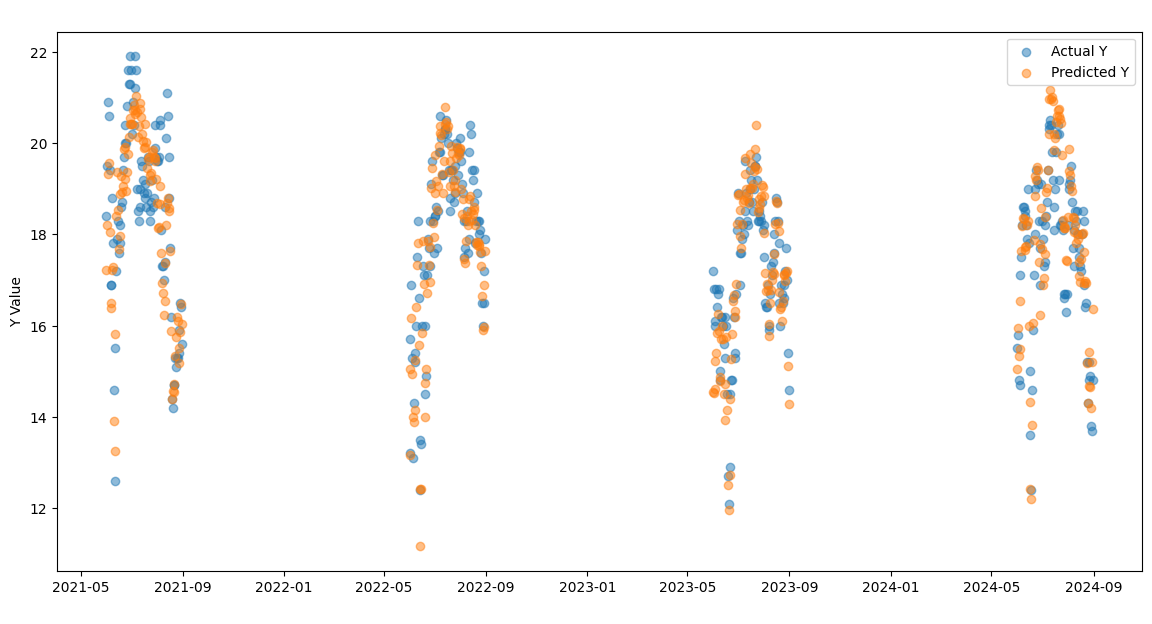

In [16]:
alpha = 0.5

plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y',alpha=alpha)
plt.title(' ')
plt.xlabel(' ')
plt.ylabel('Y Value')
plt.legend()
plt.show()

In [14]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[ best_params['model__h1']]
                           ,"h1_range":[h1]
                          ,"h2":[ best_params['model__h2'] ]
    ,"h2_range":[h2]
                          ,"d1":[ best_params['model__d1'] ]
    ,"d1_range":[d1]
                          ,"d2":[ best_params['model__d2'] ]
    ,"d2_range":[d2]
                          ,"batch":[ best_params['batch_size']]
    ,"batch_range":[batch_size]
                          ,"look_back":[look_back]


    ,'learning_rate':[ best_params['model__learning_rate'] ]
    ,'learning_rate_range':[learning_rate]
    #,"r2" :[r2]
    ,"NSE" :[ evaluator.nash_sutcliffe_efficiency() ]
    , "rmse":[rmse]
                         #  , "bias":[bias]
                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]
    ,"KGE" : [kge_value]
,"KGE_r_comp" : [r_comp]
,"KGE_alpha_comp" : [alpha_comp]
,"KGE_beta_comp" : [beta_comp]
    })

print(result_df)




result_df.to_csv('/content/drive/My Drive/LSTM_DOY/LSTM_results_DOY_grid_search/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)




                current_time model_site      train_month   h1   h1_range  h2  \
0 2025-06-27 23:23:30.427600   13150430  [4, 5, 6, 7, 8]  128  [96, 128]  64   

   h2_range   d1     d1_range    d2  ... learning_rate  learning_rate_range  \
0  [48, 64]  0.2  [0.15, 0.2]  0.15  ...        0.0005      [0.0005, 0.001]   

        NSE      rmse  std_ratio correlation                   KGE  \
0  0.827446  0.784763   1.053328    0.919505  [0.9034351051145382]   

             KGE_r_comp        KGE_alpha_comp         KGE_beta_comp  
0  [0.9195050455121893]  [1.0533275259855441]  [0.9987686598736798]  

[1 rows x 24 columns]
